In [23]:
import pandas as pd
import numpy as np
import tqdm
import json
import matplotlib.pyplot as plt
import dataclasses

tqdm.tqdm.pandas()
plt.style.use("ggplot")

In [24]:
df = pd.read_json("./data/preprocessed/preprocessed.json", orient="index")
with open("./data/preprocessed/param.json", "r") as f:
    params = json.load(f)

In [25]:
df.head()

,valid_train_purchased_items,valid_eval_purchased_items,test_train_purchased_items,test_eval_purchased_items,valid_train_recommended_items,valid_eval_recommended_items,test_train_recommended_items,test_eval_recommended_items
0,"[3584, 2561, 3586, 3588, 3589, 3076, 522, 2061...","[2561, 516, 1157, 1159, 2061, 1038, 1171, 791,...","[3584, 2561, 3586, 3588, 3589, 3076, 516, 522,...","[2561, 3588, 3589, 2572, 2061, 2960, 277, 2972...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2049, 1, 2, 4, 5, 9, 11, 12, 2059, 13, 18, 20...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3, 4, 8, 10, 11, 16, 19, 32, 33, 34, 37, 42, ..."
1,"[0, 1, 3076, 3591, 2055, 1543, 2571, 2575, 206...","[1029, 1931, 2833, 2836, 2342, 1576, 303, 1969...","[0, 1, 3076, 1029, 3591, 2055, 1543, 2571, 257...","[130, 2055, 392, 137, 2824, 1931, 268, 1296, 2...","[0, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 16, 19, 2...","[2048, 2049, 2, 5, 6, 2055, 9, 2059, 11, 13, 1...","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16...","[2048, 1, 2049, 3, 5, 6, 7, 8, 2058, 2059, 19,..."
2,"[5, 2055, 2057, 2058, 2060, 2065, 2067, 2068, ...","[5, 2577, 1554, 531, 2068, 2075, 1564, 2082, 1...","[5, 2055, 2057, 2058, 2060, 2065, 2067, 2068, ...","[517, 2058, 1035, 2065, 2577, 1043, 2068, 531,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2, 5, 12, 13, 26, 27, 35, 42, 44, 47, 57, 58,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2, 3, 7, 10, 11, 19, 26, 29, 30, 33, 34, 41, ..."
3,"[1536, 3073, 4, 2570, 2571, 2060, 524, 1551, 3...","[2304, 2695, 906, 2060, 2957, 2446, 527, 1295,...","[1536, 3073, 4, 2570, 2571, 2060, 524, 1551, 5...","[906, 2446, 21, 802, 1061, 936, 937, 45, 2222,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16...","[2049, 1, 2, 5, 2054, 2055, 11, 12, 2064, 2067...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16...","[2049, 3, 6, 2055, 2054, 2060, 2068, 2071, 25,..."
4,"[2571, 2069, 1564, 1054, 34, 2101, 2623, 2626,...","[1923, 3076, 1159, 2187, 1296, 1044, 1818, 924...","[3076, 2571, 1044, 2069, 1564, 1054, 34, 2101,...","[9, 143, 2071, 1176, 2331, 2086, 3116, 2222, 8...","[0, 6, 13, 26, 27, 29, 30, 31, 33, 34, 35, 38,...","[2049, 1029, 5, 1033, 1036, 2067, 2068, 2069, ...","[0, 5, 6, 13, 26, 27, 29, 30, 31, 33, 34, 35, ...","[1, 2049, 3, 1026, 6, 2055, 3078, 11, 2059, 30..."


In [26]:
params

{'user_n': 1096, 'item_n': 3664}

In [27]:
EPS = 1e-8

@dataclasses.dataclass
class Args:
    mode: str = "valid"
    sampling: str = "ulrmf"
    seed: int = 0
    alpha: float = 0.6
    gamma_p: float = 0.2
    gamma_r: float = 0.5
    eta: float = 1e-2
    lmda: float = 1e-2
    d: int = 100
    batch_size: int = 1
    epochs: int = 5_000_000
    step_size: int = 10_000

USER_N = params["user_n"]
ITEM_N = params["item_n"]

print(f"user_n = {USER_N}, item_n = {ITEM_N}")

user_n = 1096, item_n = 3664


In [28]:
df_dict = df.to_dict(orient="index")

df_set = df.copy()
for col in df.columns:
    df_set[col] = df_set[col].apply(lambda x: set() if x is None else set(x))

df_set_dict = df_set.to_dict(orient="index")

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sample_rmf(rnd: np.random.RandomState, args: Args) -> tuple[int, int, int]:
    C_P = 0
    C_NP = 1
    u = rnd.randint(0, USER_N)
    C = rnd.choice([C_P, C_NP], p=[args.gamma_p, 1 - args.gamma_p])

    if C == C_P:
        r_ui = 1
        i = rnd.choice(df_dict[u][f"{args.mode}_train_purchased_items"])
    else:
        r_ui = 0
        while True:
            i = rnd.randint(0, ITEM_N)
            if i not in df_set_dict[u][f"{args.mode}_train_purchased_items"]:
                break

    return u, i, r_ui


def sample_ulrmf(rnd: np.random.RandomState, args: Args) -> tuple[int, int, int]:
    C_RP = 0
    C_NR_NP = 1
    C_other = 2
    p_C_RP = args.gamma_p * args.gamma_r
    p_C_NR_NP = (1 - args.gamma_p) * (1 - args.gamma_r)
    p_C_other = 1 - p_C_RP - p_C_NR_NP

    u = rnd.randint(0, USER_N)
    C = rnd.choice([C_RP, C_NR_NP, C_other], p=[p_C_RP, p_C_NR_NP, p_C_other])

    if C == C_RP:
        r_ui = 1

        while True:
            i = rnd.choice(df_dict[u][f"{args.mode}_train_purchased_items"])
            if i in df_set_dict[u][f"{args.mode}_train_recommended_items"]:
                break
    elif C == C_NR_NP:
        if rnd.random() <= args.alpha:
            r_ui = 1
        else:
            r_ui = 0

        while True:
            i = rnd.randint(0, ITEM_N)
            if (
                i not in df_set_dict[u][f"{args.mode}_train_purchased_items"]
                and i not in df_set_dict[u][f"{args.mode}_train_recommended_items"]
            ):
                break
    else:
        r_ui = 0

        while True:
            i = rnd.randint(0, ITEM_N)
            if (
                i in df_set_dict[u][f"{args.mode}_train_purchased_items"]
                and i not in df_set_dict[u][f"{args.mode}_train_recommended_items"]
            ) or (
                i not in df_set_dict[u][f"{args.mode}_train_purchased_items"]
                and i in df_set_dict[u][f"{args.mode}_train_recommended_items"]
            ):
                break

    return u, i, r_ui


def eval(X_u: np.ndarray, X_v: np.ndarray, k: int, args: Args) -> tuple[float, float]:
    acc = 0
    uplift = 0
    target_user_n = 0

    for u in range(USER_N):
        if df_dict[u][f"{args.mode}_eval_purchased_items"] is None:
            continue
        L_M = set(np.matmul(X_u[u], X_v.T).argsort()[-k:])
        L_D = set(df_dict[u][f"{args.mode}_eval_recommended_items"])
        L_M_and_D = list(L_M & L_D)
        L_M_not_D = list(L_M - L_D)

        Y = set(df_dict[u][f"{args.mode}_eval_purchased_items"])

        if len(L_M_and_D) > 0 and len(L_M_not_D) > 0:
            # print(len(L_M_and_D), len(L_M_not_D), len(L_M), len(L_D))
            tau = sum([1 if e in Y else 0 for e in L_M_and_D]) / len(L_M_and_D) - sum(
                [1 if e in Y else 0 for e in L_M_not_D]
            ) / len(L_M_not_D)
            uplift += tau

            v = len(L_M & Y)
            acc += v

            target_user_n += 1

    accuracy = acc / target_user_n / k
    uplift = uplift / target_user_n

    print(f"Target user N  = {target_user_n}")
    print(f"Accuracy@{k}    = {accuracy}")
    print(f"Uplift@{k}      = {uplift}")

    return accuracy, uplift


def train(args: Args) -> tuple[np.ndarray, np.ndarray, list[float]]:
    rnd = np.random.RandomState(args.seed)
    X_u = rnd.normal(size=(USER_N, args.d))
    X_v = rnd.normal(size=(ITEM_N, args.d))

    losses = []

    for t in range(args.epochs):
        if args.sampling == "ulrmf":
            u, i, r_ui = sample_ulrmf(rnd=rnd, args=args)
        elif args.sampling == "rmf":
            u, i, r_ui = sample_rmf(rnd=rnd, args=args)
        else:
            assert False

        x_ui = sigmoid(np.dot(X_u[u], X_v[i]))

        X_u[u] -= args.eta * ((x_ui - r_ui) * X_v[i] + 2 * args.lmda * X_u[u])
        X_v[i] -= args.eta * ((x_ui - r_ui) * X_u[u] + 2 * args.lmda * X_v[i])

        L = -(r_ui * np.log(max(EPS, x_ui)) + (1 - r_ui) * np.log(max(EPS, 1 - x_ui)))
        losses.append(L)

        if (t + 1) % args.step_size == 0:
            print(
                f"[{t+1:8}/{args.epochs}] {sum(losses[-args.step_size:]) / args.step_size:.5}",
                end="\r",
            )

    return X_u, X_v, losses

In [30]:
# alphas = np.linspace(0.0, 1.0, 6)
# accuracys, uplifts = [], []

# for alpha in alphas:
#     args = Args()
#     args.alpha = alpha
#     X_u, X_v, losses = train(args=args)
#     accuracy, uplift = eval(X_u=X_u, X_v=X_v, k=30, args=args)
#     accuracys.append(accuracy)
#     uplifts.append(uplift)

# plt.plot(alphas, uplifts, label="UpLift")
# plt.plot(alphas, accuracys, label="Accuracy")
# plt.xlabel("alpha")
# plt.legend()

Target user N  = 101942044
Accuracy@10    = 0.16820412168792936
Uplift@10      = 0.03726225524557218
Target user N  = 1039
Accuracy@30    = 0.12832852101379533
Uplift@30      = 0.045265277382364515
Target user N  = 1041
Accuracy@100    = 0.0771373679154659
Uplift@100      = 0.036168659545894585
Target user N  = 100561836
Accuracy@10    = 0.11074626865671641
Uplift@10      = 0.1146525309958146
Target user N  = 1038
Accuracy@30    = 0.06734104046242774
Uplift@30      = 0.10400619991691397
Target user N  = 1041
Accuracy@100    = 0.03902017291066282
Uplift@100      = 0.08215465258212692


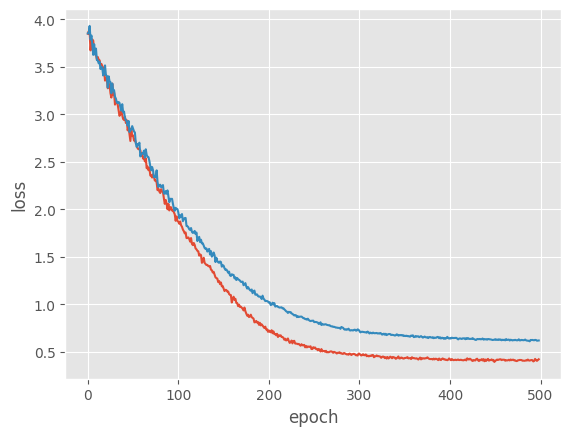

In [31]:
for sampling in ["rmf", "ulrmf"]:
    args = Args(sampling=sampling)
    X_u, X_v, losses = train(args)
    for k in [10, 30, 100]:
        eval(X_u, X_v, k=k, args=args)

    plt.plot([sum(losses[i : i + args.step_size]) / args.step_size for i in range(args.step_size, args.epochs, args.step_size)])
    plt.xlabel("epoch")
    plt.ylabel("loss")

In [32]:
# np.save("./model/ulrmf_X_u_alpha=06.npy", X_u)
# np.save("./model/ulrmf_X_v_alpha=06.npy", X_v)

# X_u = np.load("./model/ulrmf_X_u.npy")
# X_v = np.load("./model/ulrmf_X_v.npy")

# np.save("./model/rmf_X_u.npy", X_u)
# np.save("./model/rmf_X_v.npy", X_v)

# X_u = np.load("./model/rmf_X_u.npy")
# X_v = np.load("./model/rmf_X_v.npy")

$$
-(r_{ui} \log \sigma (\hat{x}_{ui}) + (1 - r_{ui}) \log (1 - \sigma (\hat{x}_{ui})))
$$